# Previsão Idade Xception

### Imports necessários

In [1]:
import tensorflow.keras as keras
import pandas as pd
import numpy as np
import os, shutil
import matplotlib.pyplot as plt
from PIL import Image

## Recuperação dos dados dos ficheiros relativamente as imagens/labels

In [2]:
import csv
results = []
with open("HalfData.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_ALL) # change contents to floats
    for row in reader: # each row is a list
        results.append(row)

In [4]:
labelslist = []
label =""
for i in range(len(results)):
    age = int(results[i][0])
    if(age>=18 and age<=21):
        label = "18_21"
    if(age>=22 and age<=24):
        label = "22_24"
    if(age>=25 and age<=28):
        label = "25_28"
    if(age>=29 and age<=33):
        label = "29_33"
    if(age>=34 and age<=40):
        label = "34_40"
    if(age>=41 and age<=47):
        label = "41_47"
    if(age>=48 and age<=55):
        label = "48_55"
    if(age>=56 and age<=65):
        label = "56_65"
    labelslist.append(label)

In [5]:
labels = np.reshape(labelslist,len(labelslist))
labels

array(['56_65', '22_24', '34_40', ..., '25_28', '48_55', '25_28'],
      dtype='<U5')

In [6]:
import collections
print(len(labels))
collections.Counter(labels)

13877


Counter({'56_65': 1346,
         '22_24': 1675,
         '34_40': 1987,
         '41_47': 1603,
         '25_28': 2333,
         '29_33': 2156,
         '48_55': 1561,
         '18_21': 1216})

In [7]:
teste = (np.reshape(np.fromfile("HalfData"),(13877,256,256))).astype('float16')

In [8]:
teste

array([[[0.1562 , 0.1562 , 0.1562 , ..., 0.118  , 0.1179 , 0.1218 ],
        [0.1562 , 0.1562 , 0.1562 , ..., 0.118  , 0.1179 , 0.1218 ],
        [0.1562 , 0.1562 , 0.1562 , ..., 0.114  , 0.1179 , 0.114  ],
        ...,
        [0.9053 , 0.882  , 0.8936 , ..., 0.5767 , 0.54   , 0.548  ],
        [0.9053 , 0.9014 , 0.925  , ..., 0.5986 , 0.5557 , 0.548  ],
        [0.93   , 0.93   , 0.942  , ..., 0.5986 , 0.54   , 0.552  ]],

       [[0.9683 , 0.9683 , 0.9683 , ..., 0.985  , 0.985  , 0.985  ],
        [0.9683 , 0.9683 , 0.9683 , ..., 0.985  , 0.985  , 0.985  ],
        [0.9683 , 0.9683 , 0.9683 , ..., 0.985  , 0.985  , 0.985  ],
        ...,
        [0.9243 , 0.9165 , 0.8784 , ..., 0.709  , 0.709  , 0.709  ],
        [0.922  , 0.8994 , 0.8916 , ..., 0.977  , 0.977  , 0.977  ],
        [0.917  , 0.8984 , 0.9023 , ..., 0.9805 , 0.9805 , 0.9805 ]],

       [[0.02353, 0.02353, 0.02353, ..., 0.02846, 0.02846, 0.02846],
        [0.02353, 0.02353, 0.02353, ..., 0.02846, 0.02846, 0.02846],
    

## Divisão dos dados para treino e teste

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(teste,labels, test_size=0.20, stratify=labels, random_state = 2)

In [10]:
#1Hot encondig para as labels de treino
train_labels = pd.get_dummies(y_train)
train_labels = train_labels.to_numpy()

In [11]:
#1Hot encondig para as labels de teste
test_labels = pd.get_dummies(y_test)
test_labels = test_labels.to_numpy()

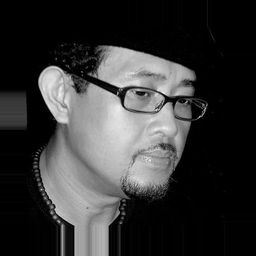

In [13]:
#Verificação da integridade dos dados -> foto reconstruivel atraves dos pontos 
image2 = Image.fromarray((X_train[0]*255).astype('uint8'))
image2

In [14]:
#Reshape para 4 dimensões (nFotos * 256pixeis * 256 pixeis * 1 canal de cor(black&white))
train_images = X_train.reshape((len(X_train), 256, 256, 1))
test_images = X_test.reshape((len(X_test), 256, 256, 1))



## Criação e treino da rede -> Xception 126layers

In [15]:
import tensorflow as tf

model = tf.keras.applications.Xception(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=(256,256,1),
    pooling=None,
    classes=8,
)

In [16]:
#Verificação das camadas existentes na rede 
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 288         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [17]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
len(train_labels)

11101

In [ ]:
for i in range (10):
    name = "XceptionAgeV" + str(i) + ".h5"
    model.fit(train_images, train_labels, epochs=3, batch_size=16)
    model.save(name)

In [82]:
from tensorflow.keras.models import load_model
modelPenultimo = load_model("XceptionAge5.h5")

In [83]:
modelBeforeOF = load_model("XceptionAge4.h5")

In [84]:
modelAfterOF = load_model("XceptionAge6.h5")

In [103]:
test_loss, test_acc = modelBeforeOF.evaluate(test_images, test_labels)

87/87 [==============================] - 13s 148ms/step - loss: 1.6980 - accuracy: 0.3004


In [86]:
test_loss, test_acc = modelPenultimo.evaluate(test_images, test_labels)

87/87 [==============================] - 13s 152ms/step - loss: 1.4010 - accuracy: 0.4416


In [87]:
test_loss, test_acc = modelAfterOF.evaluate(test_images, test_labels)

87/87 [==============================] - 13s 151ms/step - loss: 2.7084 - accuracy: 0.3372


In [88]:

def oneOff(predictions,correct):
    acc = 0
    for i in range(len(predictions)):
        if(np.argmax(predictions[i])==np.argmax(correct[i])+1):
            acc = acc + 1 ;
        if(np.argmax(predictions[i])==np.argmax(correct[i])-1): 
            acc = acc + 1 ;
        if(np.argmax(predictions[i])==np.argmax(correct[i])):
            acc = acc + 1 ;
    return (acc/len(predictions))*100;

In [89]:
def oneOfbyClass(predictions,correct):
    acc = [0,0,0,0,0,0,0,0]
    listaLabels = ["18_21","22_24","25_28","29_33","34_40","41_47","48_55","56_65"]
        
    for i in range(len(predictions)):
        if(np.argmax(predictions[i])==np.argmax(correct[i])+1):
            acc[np.argmax(correct[i])] = acc[np.argmax(correct[i])] + 1 ;
        if(np.argmax(predictions[i])==np.argmax(correct[i])-1): 
            acc[np.argmax(correct[i])] = acc[np.argmax(correct[i])] + 1 ;
        if(np.argmax(predictions[i])==np.argmax(correct[i])):
            acc[np.argmax(correct[i])] = acc[np.argmax(correct[i])] + 1 ;
    
    listaIndices = [0,0,0,0,0,0,0,0]
    for i in range(len(correct)):
        listaIndices[np.argmax(correct[i])] = listaIndices[np.argmax(correct[i])] + 1
    
    newlista = []
    for i in range(len(listaIndices)):
        newlista.append(((acc[i]/listaIndices[i])*100,listaLabels[i]))
        
    
    
    return newlista;

In [90]:
def accByClass(predictions,correct):
    acc = [0,0,0,0,0,0,0,0]
    listaLabels = ["18_21","22_24","25_28","29_33","34_40","41_47","48_55","56_65"]

    for i in range(len(predictions)):
        if(np.argmax(predictions[i])==np.argmax(correct[i])):
            acc[np.argmax(correct[i])] = acc[np.argmax(correct[i])] + 1 ;
    
    listaIndices = [0,0,0,0,0,0,0,0]
    for i in range(len(correct)):
        listaIndices[np.argmax(correct[i])] = listaIndices[np.argmax(correct[i])] + 1
    
    newlista = []
    for i in range(len(listaIndices)):
        newlista.append(((acc[i]/listaIndices[i])*100,listaLabels[i]))
    
    return newlista;

In [91]:
predictionsBOF = modelBeforeOF.predict(test_images)

In [92]:
predictionsPOF = modelPenultimo.predict(test_images)

In [93]:
predictionsAOF = modelAfterOF.predict(test_images)

### One Off

In [94]:
oneOff(predictionsBOF,test_labels)

71.00144092219021

In [95]:
oneOff(predictionsPOF,test_labels)

82.63688760806916

In [96]:
oneOff(predictionsAOF,test_labels)

60.30259365994236

### One Off By Class

In [97]:
oneOfbyClass(predictionsBOF,test_labels)

[(12.345679012345679, '18_21'),
 (71.04477611940298, '22_24'),
 (82.86937901498929, '25_28'),
 (95.82366589327145, '29_33'),
 (78.14070351758794, '34_40'),
 (71.33956386292834, '41_47'),
 (61.858974358974365, '48_55'),
 (63.19702602230484, '56_65')]

In [98]:
oneOfbyClass(predictionsPOF,test_labels)

[(60.49382716049383, '18_21'),
 (69.85074626865672, '22_24'),
 (87.15203426124198, '25_28'),
 (90.25522041763341, '29_33'),
 (93.96984924623115, '34_40'),
 (84.42367601246106, '41_47'),
 (80.44871794871796, '48_55'),
 (82.15613382899627, '56_65')]

In [99]:
oneOfbyClass(predictionsAOF,test_labels)

[(99.58847736625515, '18_21'),
 (96.71641791044776, '22_24'),
 (10.06423982869379, '25_28'),
 (12.064965197215777, '29_33'),
 (58.040201005025125, '34_40'),
 (72.89719626168224, '41_47'),
 (92.62820512820514, '48_55'),
 (94.79553903345726, '56_65')]

### Accuracy By Class

In [100]:
accByClass(predictionsBOF,test_labels)

[(12.345679012345679, '18_21'),
 (0.0, '22_24'),
 (59.743040685224834, '25_28'),
 (32.71461716937355, '29_33'),
 (40.7035175879397, '34_40'),
 (22.429906542056074, '41_47'),
 (31.73076923076923, '48_55'),
 (18.95910780669145, '56_65')]

In [101]:
accByClass(predictionsPOF,test_labels)

[(40.32921810699588, '18_21'),
 (28.059701492537314, '22_24'),
 (37.47323340471092, '25_28'),
 (61.48491879350348, '29_33'),
 (55.527638190954775, '34_40'),
 (36.44859813084112, '41_47'),
 (29.807692307692307, '48_55'),
 (60.594795539033456, '56_65')]

In [102]:
accByClass(predictionsAOF,test_labels)

[(98.76543209876543, '18_21'),
 (2.9850746268656714, '22_24'),
 (0.21413276231263384, '25_28'),
 (6.0324825986078885, '29_33'),
 (31.4070351758794, '34_40'),
 (48.598130841121495, '41_47'),
 (43.91025641025641, '48_55'),
 (89.59107806691449, '56_65')]

## Sistema de Inferência por imagem de input

In [104]:
def predictAge(predictionsPOF):
        age = np.argmax(predictionsPOF)
        switcher={
                0:'18_21',
                1:'22_24',
                2:'25_28',
                3:'29_33',
                4:'34_40',
                5:'41_47',
                6:'48_55',
                7:'56_65'
             }
        return switcher.get(age,"Invalid index")

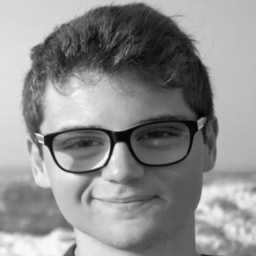

In [105]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3],[0.2989,0.5870,0.1140])


imgTeste = Image.open("dias.jpg")
data = np.asarray(imgTeste)/255
if(len(data.shape)>2):
    data = rgb2gray(data)
img =  Image.fromarray((data*255).astype('uint8'))
img2CNN =  data.reshape(1, 256, 256, 1)
img

In [106]:
predictAge(modelPenultimo.predict(img2CNN))

'18_21'

## Verificação de Versões para GPU

In [81]:
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Tensor Flow Version: 2.2.0
Keras Version: 2.3.0-tf

Python 3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
Pandas 1.0.4
Scikit-Learn 0.22.1
GPU is available
